# Лабораторная работа №7. Решающие деревья. Усиление распознавателей

В данной лабораторной работе рассматривается использование бинарных распознающих деревьев и их ансамблей для решения задачи классификации.

Распознающим бинарным деревом называется дерево, с каждой вершиной $v$ которого связаны:

1. Некоторое подмножество $\mathcal{X}_v \subset \mathcal{X}$;
1. Подвыборка $\mathcal{D}_v \subset \mathcal{D}$ обучающей выборки $\mathcal{D}$, такая, что
$$
    \mathcal{D}_v = \left\{(\mathbf{x}, t) \in \mathcal{D} \,\vert\, \mathbf{x} \in \mathcal{X}_v\right\};
$$
1. Некоторое правило $f_v: \mathcal{X} \to \{0, 1\}$, определяющее разбиение множества $\mathcal{X}$ на $K$ непересекающихся подмножеств.

Цель построения дерева решений состоит либо в классификации векторов $\mathbf{x}$, либо в оценке математического ожидания отклика при данном значении $\mathbf{x}$.
Процесс принятия решения начинается с корневой вершины и состоит в последовательном применении правил, связанных с вершинами дерева.
Результатом этого процесса является определение терминальной вершины $v$, такой что $\mathbf{x} \in \mathcal{X}_v$.

Распознающие деревья редко применяют в качестве самостоятельного распознавателя, так как хорошего качества распознавания от них редко удается добиться.
Вместо этого их широко применяют в качестве «сырья» в методах усиления распознавателей, где синтез решения отдельных классификаторов, составляющих ансамбль, осуществляется путем их голосования.

Метод баггинга основан на формировании обучающей выборки для каждого классификатора ансамбля с помощью бутстрепа, то есть случайной выборки с возвращениями из исходной обучающей выборки.

Суть метода случайных лесов заключается в том, что для каждого дерева ансамбля на стадии расщепления вершин используется только некоторое подмножество случайно отбираемых признаков.
Чаще всего размерность такого подмножества выбирается близкой к $\sqrt{p}$, где $p$ $-$ размерность всего пространства признаков.

Идея метода бустинга состоит в том, что классификаторы ансамбля строятся последовательно, и на каждой итерации происходит коррекция (перевзвешивание) образов обучающей выборки.
Коррекция осуществляется таким образом, чтобы соответствующий классификатор дал меньше ошибок на тех образах, на которых часто делали ошибки классификаторы, построенные на предыдущих итерациях алгоритма.
Кроме того, каждому классификатору приписывается некоторый вес исходя из количества допущенных им ошибок.

In [208]:
import numpy as np
import sklearn as sk
import sklearn.datasets
import sklearn.model_selection
import sklearn.tree
import sklearn.ensemble
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Задание №1

Сгенерируйте датасет с 2 признаками размером 3000 строк (`n_informative=2`, остальные параметры следует установить в 0).
В качестве `random_state` используйте свой порядковый номер в списке.
Разделите датасет на обучающую и тестовую выборки.
Размер тестовой выборки следует выбрать равным 20% от размера всей выборки.
Не забывайте про параметр `random_state` для повторяемости результатов.

(2400, 2) (2400,)


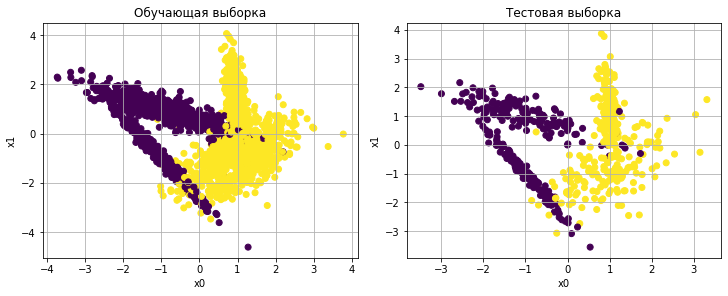

In [211]:
x, y = sk.datasets.make_classification(n_samples=3000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=1)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state=42, test_size = 0.2)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*5, 4))
ax0.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
ax0.set(xlabel='x0', ylabel='x1', title='Обучающая выборка')

ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set(xlabel='x0', ylabel='x1', title='Тестовая выборка')

print(x_train.shape, y_train.shape)

## Задание №2

Найдите наилучшие параметры решающего дерева `DecisionTreeClassifier`.
Для этого постройте графики зависимостей _accuracy_ от сложности модели (максимального числа разделений) для обучающей и тестовой выборок.
После чего выберите оптимальное значение сложности модели.

**Замечание.**
Оптимальные параметры следует выбирать по наилучшему значению на тестовой выборке.
Если в исследуемой зависимости наблюдается несколько пиков с наилучшим значением, то стоит принять в рассмотрение также результат на обучающей выборке.

criterion: gini max_depth: 4
Max test accuracy value 0.965
Train accuracy value for max_depth getting max test accuracy value 0.9708333333333333
criterion: entropy max_depth: 7
Max test accuracy value 0.9683333333333334
Train accuracy value for max_depth getting max test accuracy value 0.97875


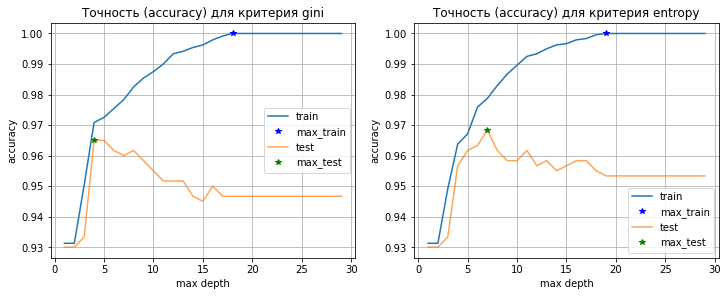

In [217]:
max_depth = range(1, 30)
criterions = ["gini", "entropy"]
_, axes = plt.subplots(1, len(criterions), figsize=(len(criterions)*5, 4))
for criterion, ax in zip(criterions, axes):
    metrics_train, metrics_test = [], []
    for depth in max_depth:
        model = sklearn.tree.DecisionTreeClassifier(criterion=criterion, splitter="best", max_depth=depth, random_state=0)
        model.fit(x_train,y_train)
        model.predict(x_test)
        metrics_train.append(model.score(x_train, y_train))
        metrics_test.append(model.score(x_test, y_test))
    
    max_train = np.argmax(metrics_train)
    max_test = np.argmax(metrics_test)
    
    ax.plot(max_depth, metrics_train, label='train')
    ax.plot(max_depth[max_train], metrics_train[max_train], 'b*', label='max_train')
    ax.plot(max_depth, metrics_test, label='test', alpha=0.7)
    ax.plot(max_depth[max_test], metrics_test[max_test], 'g*', label='max_test')
    ax.set(xlabel='max depth', ylabel='accuracy', title='Точность (accuracy) для критерия ' + criterion)
    ax.legend()
    
    print("criterion:", criterion, 'max_depth:', max_depth[max_test])
    print("Max test accuracy value",metrics_test[max_test])
    print("Train accuracy value for max_depth getting max test accuracy value",metrics_train[max_test])

**Вопросы:**

1. Какие критерии были рассмотрены?
1. Запишите полученную наилучшую точность и максимальное число разделений для каждого критерия.
1. Какой критерий разделения дает наилучший результат?
1. Наблюдается ли эффект переобучения (если да, то с чем он связан)?

**Ответы:**

1. Были рассмотрены критерии `gini` (индекс Джини) и `entropy` (энтропия).
1. Наилучшая точность на тестовой выборке: 0.968; максимальное число разделений: 7.
1. Критерий разделения `entropy` даёт наилучший результат по точности.
1. Да, эффект переобучения наблюдается. Это можно видеть по убыванию графика точности на тестовой выборке при продолжении его роста на обучающей выборке. Переобучение связано с тем, что при больших значениях глубины дерева `max_depth` модель сильно подстраивается под расположение точек из обучающей выборки и начинает плохо классифицировать точки из выборки тренировочной.

Визуализируйте разделение пространства признаков для наилучшей модели.

train 0.97875
test 0.9683333333333334


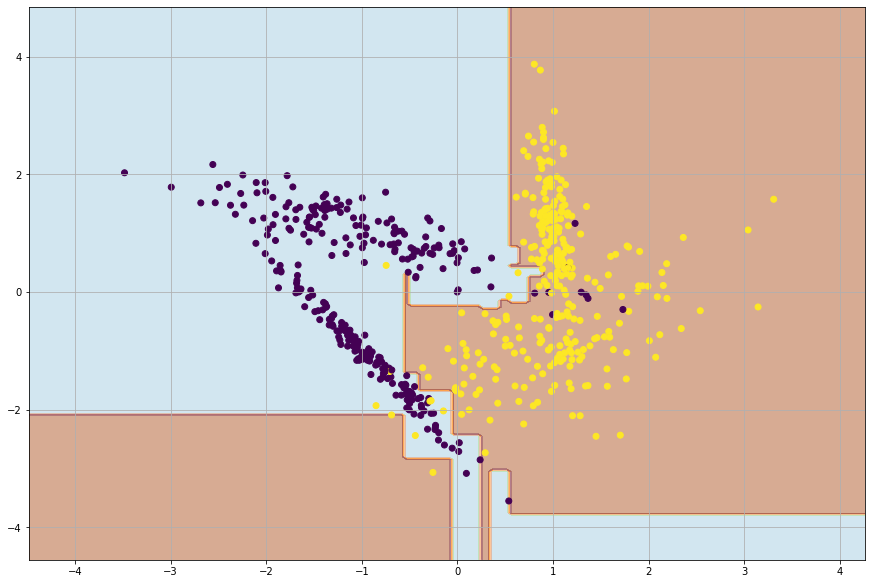

In [218]:
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

best_model = sklearn.tree.DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=7, random_state=0)
best_model.fit(x_train,y_train)
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
print('train', best_model.score(x_train, y_train))
print('test', best_model.score(x_test, y_test))

**Вопросы:**

1. Чем характерно отличается полученное разбиение от тех вариантов, что получались в прошлых лабораторных работах?

**Ответы:**

1. Разбиение формируется только прямыми вертикальными или горизонтальными линиями, т. е. пространство признаков разбивается на так называемые "ящики".

## Задание №3

Найдите наилучшие параметры ансамбля, полученного баггингом `BaggingClassifier`.
Для этого воспользуйтесь функцией `GridSearchCV` с указанием кросс-валидации.
Рассмотрите такие параметры перебора:

* Максимальное число разделений (от 1 до 20)
* Максимальное доля обучающей выборки
* Количество деревьев в ансамбле (от 1 до 100)

Шаг для перебора каждого из параметров можете выбрать самостоятельно.
Визуализируйте разделение пространства признаков для наилучшей модели.

{'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=0), 'max_samples': 0.3194736842105263, 'n_estimators': 37}
train 0.9758333333333333
test 0.9683333333333334
Wall time: 34min 22s


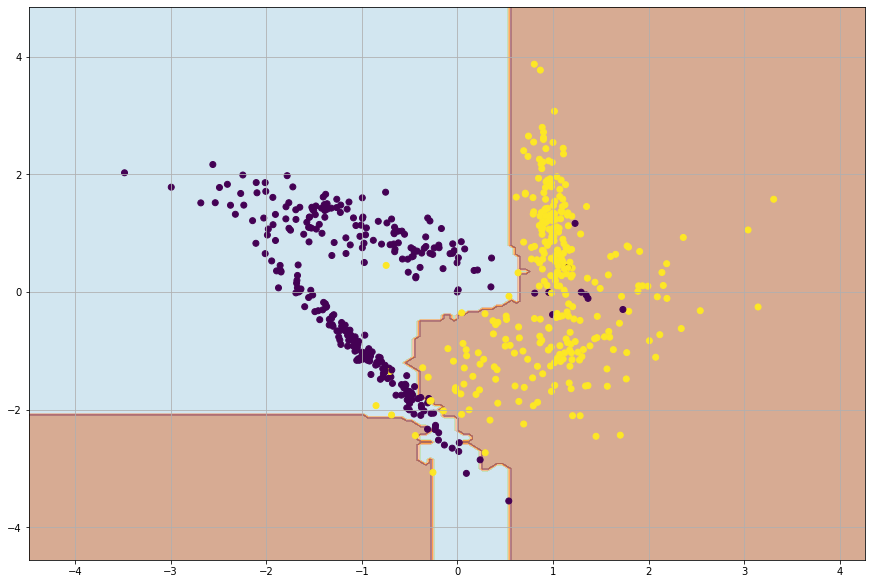

In [219]:
%%time
list_est = [sklearn.tree.DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=md, random_state=0) for md in range(12)]
param_grid = {
    'base_estimator' : list_est,
    'max_samples' : np.linspace(0.01, 0.99, 20),
    'n_estimators' : np.linspace(1,100,20).astype(int)}

gs = sk.model_selection.GridSearchCV(sklearn.ensemble.BaggingClassifier(random_state=0),
                                     param_grid=param_grid, return_train_score=True, n_jobs=-1)
gs.fit(x_train, y_train)

Z = gs.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)

print(gs.best_params_)
print('train', gs.best_estimator_.score(x_train, y_train))
print('test', gs.best_estimator_.score(x_test, y_test))

**Вопросы:**

1. Удалось ли увеличить качество модели по сравнению с одним распознающим деревом?
1. Как и почему изменилась форма разделяющей поверхности?
1. Как изменилась оптимальная сложность деревьев по сравнению с предыдущим заданием и с чем это связано?

**Ответы:**

1. В данном случае не удалось увеличить качество модели.
1. Полученная форма разделяющей поверхности лучше локализует области, соответствующие различным классам, по сравнению с одним распознающим деревом. При использовании ансамбля деревьев принадлежность точки к тому или иному классу на основе её положения в пространстве признаков определяется как самый частый отклик деревьев, входящих в ансамбль. Следовательно, и форма разделяющей поверхности будет зависеть от всех деревьев, входящих в ансамбль, а потому она будет иметь уже другой вид, отличающийся от случая с одним деревом.
1. Оптимальная сложность деревьев по сравнению с предыдущим заданием увеличилась.

Проанализируйте зависимости _accuracy_ от конкретных параметров.
Для этого используйте информацию из словаря `cv_results_`, беря во внимание полученные оптимальные параметры `best_params_`.
Постройте графики зависимости среднего значения _accuracy_ для каждого из параметров, фиксируя остальные параметры в значениях, взятых из `best_params_`.
Графики должны быть построены для обучающей и тестовой выборок, также показан разброс на тестовой выбоке (разброс вычисляется благодаря кросс-валидации).

{'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=0), 'max_samples': 0.3194736842105263, 'n_estimators': 37}


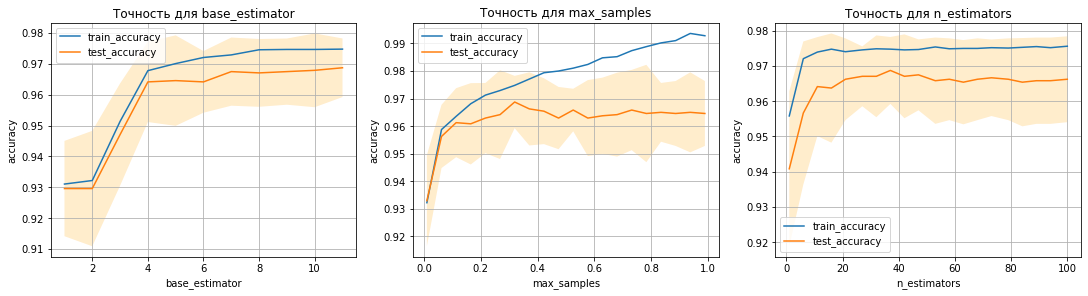

In [220]:
print(gs.best_params_)

_, axes = plt.subplots(1, len(gs.best_params_), figsize=(len(gs.best_params_)*5, 4))
for param, ax in zip(list(gs.best_params_.keys()), axes):
    reduced_dict = {k:v for k, v in gs.best_params_.items() if k != param}
    idx = [i for i, x in enumerate(gs.cv_results_['params']) if reduced_dict.items() <= x.items()]

    x, y, t, s = (gs.cv_results_[l][idx] for l in [f'param_{param}', 'mean_train_score', 'mean_test_score', 'std_test_score'])
    if (param == 'base_estimator'):
        x = np.array([k.max_depth for k in x])
        x = x[1:]
        y = y[1:]
        t = t[1:]
        s = s[1:]

    ax.plot(x.data, y, label='train_accuracy')
    ax.plot(x.data, t, label='test_accuracy')
    ax.fill_between(list(x.data), t - 2 * s, t + 2 * s, facecolor='orange', alpha=.2)
    ax.set(xlabel=param, ylabel='accuracy', title='Точность для ' + param)
    ax.legend()

**Вопросы:**

1. Опишите поведение графиков для каждого из параметров.
1. Изменился ли график максимального количества разбиения по сравнению с предыдущим вариантом? Почему?
1. Как связаны оптимальная сложность деревьев и количество распознающих деревьев?
1. За что отвечает параметр `max_samples`?

**Ответы:**

1. По 1 и 3 графикам можно видеть, что с увеличением параметров `max_depth` и `n_estimators` соответственно значения точности на обучающей и тестовой выборках растут примерно с одинаковой скоростью. По графику 2 видно, что, начиная с точки `max_samples` $\approx 0.3$, скорость роста точности на обучающей выборке становится заметно больше скорости роста точности на выборке тестовой, что свидетельствует о возникновении переобучения.
1. Точка `max_depth`, соответствующая максимуму точности на тестовой выборке, сместилась с 7 до 11.
1. В данном случае при `n_estimators` $= 37$ глубина деревьев выросла с 7 до 11, по сравнению со случаем с одним деревом. Т. е. с ростом кол-ва деревьев сложность возросла, однако обычно при росте `n_estimators` значение `max_depth` уменьшается.
1. Параметр `max_samples` отвечает за число элементов обучающей выборки, которые используются для обучения каждого из деревьев.

## Задание №4

Подготовьте датасет mnist через функцию `load_digits` для дальнейшей работы.
Преобразуйте каждое изображение в одномерный вектор нормированных признаков.
Разделите датасет на обучающую и тестовую выборки.
Размер тестовой выборки следует выбрать равным 20% от размера всей выборки.
Не забудьте указать `random_state` для повторяемости результатов.

In [221]:
x, y = sklearn.datasets.load_digits(return_X_y=True)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state=42, test_size = 0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1437, 64) (360, 64) (1437,) (360,)


## Задание №5

Найдите наилучшие параметры для ансамблей, полученных баггингом, методом адаптивного бустинга, а также случайного леса с помощью `GridSearchCV`.
Выведите _accuracy_ для обучающей и тестовой выборок.
Параметры переборов:

* Макимальная глубина деревьев - от 1 до 20
* Количество деревьев - от 10 до 100
* `max_samples` и `max_features` - от 0 до 1

In [206]:
tree_prototype = sk.tree.DecisionTreeClassifier(random_state=4)

params = {
    'BaggingClassifier': {
        'proto': sk.ensemble.BaggingClassifier(base_estimator=tree_prototype, random_state=4),
        'grid': {
            'base_estimator__max_depth': np.linspace(1,20,20).astype(int),
            'n_estimators': np.linspace(10,100,10).astype(int),
            'max_samples': np.linspace(1,x_train.shape[0],x_train.shape[0] // (x_train.shape[0] // 10))}},
    'RandomForestClassifier': {
        'proto': sk.ensemble.RandomForestClassifier(random_state=4),
        'grid': {
            'max_depth': np.linspace(1,20,20).astype(int),
            'n_estimators': np.linspace(10,100,10).astype(int),
            'max_features': np.linspace(1,x_train.shape[0],x_train.shape[0] // (x_train.shape[0] // 10))}},
    'AdaBoostClassifier': {
        'proto': sk.ensemble.AdaBoostClassifier(base_estimator=tree_prototype,random_state=4),
        'grid': {
            'base_estimator__max_depth' : np.linspace(1,20,20).astype(int),
            'n_estimators' : np.linspace(10,100,10).astype(int)}}}

for (name, param) in params.items():
    gs = sk.model_selection.GridSearchCV(param['proto'], param_grid=param['grid'], n_jobs=-1)
    %time gs.fit(x_train, y_train)
    print(name, gs.best_params_)
    print('train', gs.best_estimator_.score(x_train, y_train))
    print('test', gs.best_estimator_.score(x_test, y_test))

Wall time: 4min 45s
BaggingClassifier {'base_estimator__max_depth': 13, 'max_samples': 1.0, 'n_estimators': 80}
train 1.0
test 0.9444444444444444
Wall time: 6min 30s
RandomForestClassifier {'max_depth': 13, 'max_features': 1.0, 'n_estimators': 60}
train 1.0
test 0.95
Wall time: 2min 48s
AdaBoostClassifier {'base_estimator__max_depth': 10, 'n_estimators': 90}
train 1.0
test 0.9777777777777777


**Вопросы:**

1. Какова оптимальная размерность подмножества случайно отбираемых признаков для случайного леса?
1. Какой метод позволил достичь наилучшего результата?
1. Что можно сказать о скорости обучения ансамблей?

**Ответы:**

1. Оптимальное значение `max_features` равно 1.0, т. е. подмножество отбираемых признаков для случайного леса совпадает со всем множеством признаков и равно 64.
1. Наилучшего по точности результата достиг метод адаптивного бустинга (`AdaBoostClassifier`).
1. Быстрее всех обучился метод адаптивного бустинга (`AdaBoostClassifier`), на втором месте по скорости обучения - баггинг (`BaggingClassifier`), и самым медленным оказался метод случайного леса (`RandomForestClassifier`).